We will train a model using the largest dataset which corresponds to the Frontal AP data. We will then use tranfer learning to ease training the other models. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from Scripts.data_utils import grab_processed_data

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

%load_ext autoreload
%autoreload 2

Testing = False

In [2]:
inputs = []
outputs = []

if not Testing:
    labels, inputs, outputs = grab_processed_data('train_frontal_pa.csv', 'train_frontal_pa.pkl')

labels, X_val, y_val = grab_processed_data('valid_frontal_pa.csv', 'valid_frontal_pa.pkl')        

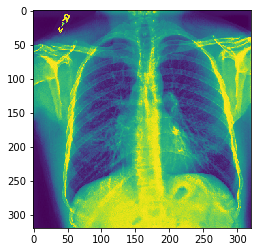

In [3]:
from random import randint

if not Testing:
    idx = randint(0, len(inputs) -1)
    img = inputs[idx]
    img = np.reshape(img, (320, 320))
    plt.imshow(img)

In [4]:
train_data = []
val_data = []
test_data = []
mean = np.zeros((1,320,320))

if Testing:
    for idx in range(len(X_val)):
        train_data.append([X_val[idx], y_val[idx]])

    mean +=  np.mean(X_val)
    print('Testing :)')

else:   
    shuffled_idxs = list(range(len(inputs)))
    np.random.shuffle(shuffled_idxs)
    
    train_cutoff = int(inputs.shape[0]*75/100)
    val_cutoff = int(inputs.shape[0]*95/100)

    for i, idx in enumerate(shuffled_idxs):
        if i < train_cutoff:
            train_data.append([inputs[idx], outputs[idx]])
        elif i < val_cutoff:
            val_data.append([inputs[idx], outputs[idx]])
        else:
            test_data.append([inputs[idx], outputs[idx]])
        
    mean += np.mean(inputs[shuffled_idxs[:train_cutoff]])

    for i in range(len(X_val)):
        test_data.append([X_val[i], y_val[i]])
        
    
    print('Total training examples = ', len(train_data))
    print('Total validation examples = ', len(val_data))
    print('Total test examples = ', len(test_data))

Total training examples =  22077
Total validation examples =  5888
Total test examples =  1505


In [5]:
if Testing:
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=16)
else:
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)
    val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=512)
    test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=512)

In [6]:
only_val_test_data = []
temp_only_val = []
only_val_loader = []

for i in range(len(X_val)):
    only_val_test_data.append([X_val[i], y_val[i]])

only_val_loader = torch.utils.data.DataLoader(only_val_test_data, shuffle=True, batch_size=16)


In [8]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 230
print(len(train_data)/32)

print('using device:', device)

689.90625
using device: cuda


In [9]:
import torchvision.models as models

model = None
optimizer = None 

learning_rate = 1e-3

mean_t = torch.tensor(mean).to(device=device, dtype=torch.float)

model = models.densenet121()
model.classifier = nn.Linear(1024, 5)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.load_state_dict(torch.load('model_15.pth'))

#model = models.alexnet(pretrained=True)
#model.classifier[6] = nn.Linear(4096,5)
#model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)

if USE_GPU and torch.cuda.is_available():
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=6e-5)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

In [10]:
#Resetting Arrays for multiple tests
loss_arr = []

Acc_Train = []
TP_Rate_Train = []
FP_Rate_Train = []
Precision_Train = []
Prevalence_Train = []

Acc_Val = []
TP_Rate_Val = []
FP_Rate_Val = []
Precision_Val = []
Prevalence_Val = []

In [11]:
def check_accuracy(loader, model):

    TP = torch.zeros(5, dtype=dtype).to(device=device, dtype=dtype)
    FP = torch.zeros(5, dtype=dtype).to(device=device, dtype=dtype)
    FN = torch.zeros(5, dtype=dtype).to(device=device, dtype=dtype)
    TN = torch.zeros(5, dtype=dtype).to(device=device, dtype=dtype)
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            x -= mean_t

            preds = (torch.sigmoid(model(x)) > 0.5).to(device=device, dtype=dtype)
            
            confusion_vector = (preds/y).to(device=device, dtype=dtype)
                
            TP = (torch.sum((confusion_vector == 1.0), dim=0).to(device=device, dtype=dtype).add(TP)).to(device=device, dtype=dtype)
            FN = (torch.sum((confusion_vector == 0.0), dim=0).to(device=device, dtype=dtype).add(FN)).to(device=device, dtype=dtype)
            FP = (torch.sum((confusion_vector == float('inf')).to(device=device, dtype=dtype), dim=0).add(FP)).to(device=device, dtype=dtype)
            TN = (torch.sum(torch.isnan(confusion_vector), dim=0).to(device=device, dtype=dtype).add(TN)).to(device=device, dtype=dtype)

        acc = ((TP+TN)/(TP+FP+FN+TN)).cpu().numpy()
        tp_rate = (TP/(TP+FN)).cpu().numpy()
        fp_rate = (FP/(FP+TN)).cpu().numpy()
        precision = (TP/(TP+FP)).cpu().numpy()
        prevalence = ((TP+FN)/(TP+FP+FN+TN)).cpu().numpy()
        
        return (acc, tp_rate, fp_rate, precision, prevalence)

In [12]:
acc, tp_rate, fp_rate, precision, prevalence = check_accuracy(only_val_loader, model)
print(acc)

[0.8787879 0.969697  1.        1.        0.969697 ]


In [13]:
import torch.nn.functional as F
############ FOR REFERENCE ############
def train(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    print(epochs)
    for e in range(epochs):
        print('Epoch num: ', e)
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float)
            x -= mean_t
            scores = model(x)
            
            loss_fn = torch.nn.BCEWithLogitsLoss()
            loss = loss_fn(scores, y)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            loss_arr.append(loss.item())
                
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                    
        print('Iteration %d, loss = %.4f' % (762, loss.item()))
            
        val_acc, tp_rate, fp_rate, precision, prevalence = check_accuracy(val_loader, model)
        Acc_Val.append(val_acc)
        TP_Rate_Val.append(tp_rate)
        FP_Rate_Val.append(fp_rate)
        Precision_Val.append(precision)
        Prevalence_Val.append(prevalence)
             
        train_acc, tp_rate, fp_rate, precision, prevalence = check_accuracy(train_loader, model)
        Acc_Train.append(train_acc)
        TP_Rate_Train.append(tp_rate)
        FP_Rate_Train.append(fp_rate)
        Precision_Train.append(precision)
        Prevalence_Train.append(prevalence)

        print('Val Acc ; Train Acc : ', np.mean(val_acc), ' ; ', np.mean(train_acc))
        print()
            

In [14]:
train(model, optimizer, epochs = 10)
torch.save(model.state_dict(), 'model_10_frontal_pa.pth')

#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()

10
Epoch num:  0
Iteration 0, loss = 0.2660
Iteration 230, loss = 0.2345
Iteration 460, loss = 0.2713
Iteration 762, loss = 0.2503
Val Acc ; Train Acc :  0.9059103  ;  0.91156405

Epoch num:  1
Iteration 0, loss = 0.3039
Iteration 230, loss = 0.2732
Iteration 460, loss = 0.3131
Iteration 762, loss = 0.3233
Val Acc ; Train Acc :  0.90777856  ;  0.9147891

Epoch num:  2
Iteration 0, loss = 0.3539
Iteration 230, loss = 0.2497
Iteration 460, loss = 0.2336
Iteration 762, loss = 0.2753
Val Acc ; Train Acc :  0.906216  ;  0.91349363

Epoch num:  3
Iteration 0, loss = 0.2379
Iteration 230, loss = 0.2214
Iteration 460, loss = 0.1348
Iteration 762, loss = 0.1680
Val Acc ; Train Acc :  0.90625  ;  0.9184309

Epoch num:  4
Iteration 0, loss = 0.1996
Iteration 230, loss = 0.2651
Iteration 460, loss = 0.2067
Iteration 762, loss = 0.1712
Val Acc ; Train Acc :  0.8983017  ;  0.9063822

Epoch num:  5
Iteration 0, loss = 0.1990
Iteration 230, loss = 0.3006
Iteration 460, loss = 0.2218
Iteration 762, los

In [15]:
model_10_arrs = []

model_10_arrs.append(loss_arr)

model_10_arrs.append(Acc_Train)
model_10_arrs.append(TP_Rate_Train)
model_10_arrs.append(FP_Rate_Train)
model_10_arrs.append(Precision_Train)
model_10_arrs.append(Prevalence_Train)

model_10_arrs.append(Acc_Val)
model_10_arrs.append(TP_Rate_Val)
model_10_arrs.append(FP_Rate_Val)
model_10_arrs.append(Precision_Val)
model_10_arrs.append(Prevalence_Val)

with open("model_10_frontal_pa.pkl", "wb") as fp:
    pickle.dump(model_10_arrs, fp)

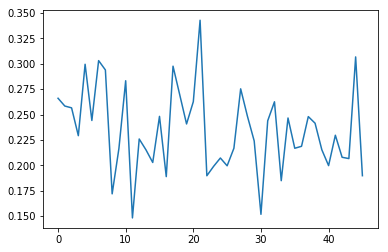

In [19]:
plt.plot(range(len(loss_arr[::150])), loss_arr[::150])

(10, 5)
(10, 5)


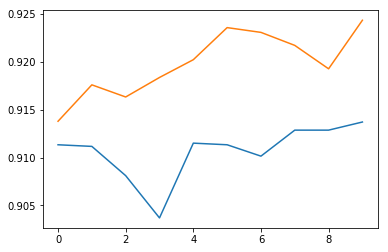

In [17]:
temp = np.asarray(Acc_Val)
print(temp.shape)
plt.plot(range(len(temp[:,1])), temp[:,1])

temp = np.asarray(Acc_Train)
print(temp.shape)
plt.plot(range(len(temp[:,1])), temp[:,1])

In [ ]:
clipped_loss = []
for element in loss_arr:
    if element > 5.0:
        clipped_loss.append(0.8)
    else:
        clipped_loss.append(element)